## MAIN GOAL OF THIS VERSION
- try to implement pandas instead of multiple arrays
- be best

## hide_toggle() setup

In [1]:
#Note that I don't actually know how this function works,
#but it doesn't really matter because I'm not looking to
#edit this function any time soon. It serves its purpose.

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

# Original Kendall Tau Setup

g_new, L_lim1  
sort_by_first, sort_by_1, kt_newform  
L_lim2, kendall_tau

In [2]:
def g_new(z, k): #The improved g-function, which transforms luminosities
    Z = z+1
    Z_c = 3.5
    return Z**k/(1+Z/Z_c)**k

def L_lim1(F_lim, z_i, d_Li, g=g_new, k=0): #finds the limiting luminosity using flux, luminosity distance, and g
    return (F_lim*1e-19)*4*math.pi*(d_Li*3.08567758e25)**2/g(z_i, k)

hide_toggle()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

def sort_by_first(A, B, reverse=False): #SORT USING Z!
    list1, list2 = zip(*sorted(zip(A, B), reverse=reverse))
    return list(list1), list(list2)

def sort_by_1(*args, reverse=False):
    thing = zip(*sorted(zip(*args), reverse=reverse))
    return [list(thang) for thang in thing]

def kt_newform(L, z, F_lim, d_L, g=g_new, k=0, func=L_lim1):
    
    #if necessary, sort by z while keeping reference to L
    z, L, d_L = sort_by_1(z, L, d_L)
        
    R = []
    E = []
    V = []
    
    for i in range(len(L)):
        higher = 0
        lower = 0
        
        #not considering data points under the cutoff
        if(L[i] < func(F_lim, z[i], d_L[i], g=g, k=k)):
            continue
        
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(F_lim, z[i], d_L[i], g=g, k=k) and z[j] <= z[i]): #associated set requirements
                
                if(L[j] > L[i]):
                    higher += 1
                else:
                    lower += 1
        
        R.append((lower+1)/(higher+lower+1))
        E.append(0.5)
        V.append(1/12)
    
    numer = sum(R) - sum(E)
    denom = (sum(V))**0.5
    return numer/denom

hide_toggle()

In [4]:
#original setup of Kendall Tau, using a generic F_lim, z --> L converter
#now only used in L-Llim space, since cannot account for d_L

def L_lim2(L_limi):
    return L_limi

def kendall_tau(L, Llim, srted=False, func=L_lim2):
    
    #if necessary, sort by z while keeping reference to L
    
    #these days I almost always assume it isn't sorted
    #bc 1) if I assume it is sorted, trouble may ensue
    #and 2) it doesn't take too long to sort it again
    
    if not srted:
        Llim, L = sort_by_first(Llim, L)
        
    R = [] # rank
    E = [] # expected value
    V = [] # (expected) variance
    
    for i in range(len(L)):
        higher = 0
        lower = 0
        
        #similar issue?
        
        if(L[i] < func(Llim[i])): #don't include sources that are not above flux limit
            continue
        
        for j in range(0, i): #since sorted by Llim now, only j < i has z_j < z_i
            if(L[j] >= func(Llim[i]) and Llim[j] <= Llim[i]): #associated set requirements
                if(L[j] > L[i]):
                    higher += 1
                else:
                    lower += 1
        
        R.append((lower+1)/(higher+lower+1))
        E.append(0.5)
        V.append(1/12)
    
    numer = sum(R) - sum(E)
    denom = (sum(V))**0.5
    return numer/denom

hide_toggle()

### import data from "frb.csv"

In [5]:
import pandas as pd
data = pd.read_csv("./data/frb.csv") 
data.columns = ['frb', 'telescope', 'snr', 'f_p', 'd_L', 'z', 'f_lim', 'L_p', 'L_lim']
data.snr = pd.to_numeric(data.snr, errors='coerce')
data.f_p = pd.to_numeric(data.f_p, errors='coerce')
data.d_L = pd.to_numeric(data.d_L, errors='coerce')
data.z = pd.to_numeric(data.z, errors='coerce')
del data['f_lim']
del data['L_p']
del data['L_lim']
ASKAP_FRBs = data.iloc[:27]
CHIME_FRBs = data.iloc[27:35]
PARKES_FRBs = data.iloc[35:]
data = pd.concat([ASKAP_FRBs, PARKES_FRBs[PARKES_FRBs.snr > 0], CHIME_FRBs], ignore_index=True)
data['telescope'][27] = 'parkes'
hide_toggle()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### derive some properties

In [6]:
data['L_p'] = (data['f_p']*1e-19)*4*math.pi*(data['d_L']*3.08567758e25)**2
f_lim = [14.8, 0.30, 0.30]
slices = [slice(0,27), slice(27,54), slice(54,62)]
a_Llim, p_Llim, c_Llim = [data['L_p'][slices[i]]*f_lim[i]/data['f_p'][slices[i]] for i in range(3)]
data['L_lim'] = pd.concat([a_Llim, p_Llim, c_Llim], ignore_index=True)
hide_toggle()

### import other properties

In [8]:
newdata = pd.read_csv("./data/DM_W_corrected.csv") 
newdata.columns = ['frb', 'telescope', 'DM', 'W', 'snr', 'f_p']
newdata.snr = pd.to_numeric(newdata.snr, errors='coerce')
newdata.DM = pd.to_numeric(newdata.DM, errors='coerce')
newdata.W = pd.to_numeric(newdata.W, errors='coerce')
newdata.f_p = pd.to_numeric(newdata.f_p, errors='coerce')
askap = newdata.iloc[:27]
chime = newdata.iloc[27:35]
parkes = newdata.iloc[35:]
newdata = pd.concat([askap, parkes[parkes.snr > 0], chime], ignore_index=True)
data['DM'], data['W'] = newdata['DM'], newdata['W']
data['fl'] = data['W']*data['f_p']
hide_toggle()

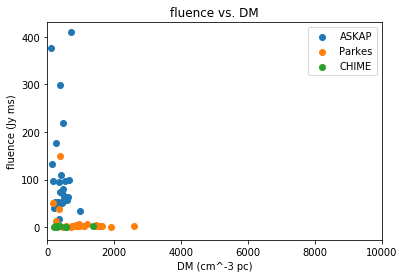

In [9]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim([0, 1e4])

ax.scatter(data['DM'][:27], data['fl'][:27], label='ASKAP')
ax.scatter(data['DM'][27:54], data['fl'][27:54], label='Parkes')
ax.scatter(data['DM'][54:], data['fl'][54:], label='CHIME')
ax.set_title('fluence vs. DM')
ax.set_xlabel('DM (cm^-3 pc)')
ax.set_ylabel('fluence (Jy ms)')
ax.legend()
plt.show()
hide_toggle()

# Kendall Tau Graph Functions

presets: ASKAP, PARKES, NEW_PARKES, CHIME, ALL  
new_L, tau_k, tkgraph  
tkplot  
tau_k2, tk_graph2  
tk_pandas, tk2_pandas

In [10]:
#Presets for the TELESCOPE option
ASKAP = (slice(0,27), 'ASKAP', 14.8, '#1f77b4')
PARKES = (slice(27,54), 'Parkes', 0.15, '#ff7f0e')
NEW_PARKES = (slice(27,54), 'Parkes', 0.30, '#ff7f0e')
NN_PARKES = (slice(27,54), 'Parkes', 0.31, '#ff7f0e')
CHIME = (slice(54,62), 'CHIME', 0.30, '#2ca02c')
ALL = (slice(0,62), 'All FRBs', 0.30, '#1f77b4')
PAC = (slice(27,62), 'Parkes + CHIME', 0.30, '#1f77b4') # PARKES + CHIME
hide_toggle()

In [11]:
def new_L(L, z, k=0, g=g_new):
    return [L[i]/g(z[i], k) for i in range(len(L))]

def tau_k(L_p, z, k, F_lim, d_L, func=L_lim1, g=g_new):
    L_new = new_L(L_p, z, k=k, g=g)
    return kt_newform(L_new, z, F_lim, d_L, g=g, k=k, func=func)

def tkgraph(L_p, z, d_L, func=L_lim1, g=g_new, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL):
    #the current k value
    k = k_min
    
    #expand telescope
    tel, telname, F_LIM, color = TELESCOPE

    #list of k, tau
    list_k = []
    list_t = []

    k1 = k_min #k closest to tau = 1
    kn1 = k_min #k closest to tau = -1
    k0 = k_min #k closest to t=0

    dif1 = 1e300 #smallest distance so far to tau = 1
    difn1 = 1e300 #smallest distance so far to tau = -1
    dif0 = 1e300

    while(k <= k_max):
        list_k.append(k)
        t_k = tau_k(L_p[tel], z[tel], k, F_LIM, d_L[tel], func=func, g=g)
        list_t.append(t_k)

        if(abs(t_k-1) < dif1):
            dif1 = abs(t_k-1)
            k1 = k
        if(abs(t_k+1) < difn1):
            difn1 = abs(t_k+1)
            kn1 = k
        if(abs(t_k) < dif0):
            dif0 = abs(t_k)
            k0 = k

        k += dk
    
    return list_k, list_t, round(k1,2), round(kn1,2), round(k0,2)

hide_toggle()

In [12]:
def tkplot(list_k, list_t, k1, kn1, k0, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL, PLOT_LINES=True, NAT=False):
    
    #expand telescope
    tel, telname, F_LIM, color = TELESCOPE

    k1, kn1, k0 = round(k1, 2), round(kn1, 2), round(k0, 2)

    YMAX, YMIN = max(list_t), min(list_t)
    XMAX, XMIN = k_max, k_min
    MAR = 0 #margin
    XMAR = MAR/10 * (abs(XMAX)+abs(XMIN)) #scaling the xmargin
    YMAR = MAR/10 * (abs(YMAX)+abs(YMIN)) #scaling the ymargin

    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(list_k, list_t, label='τ(k)')
    ax.plot(list_k, [0 for i in range(len(list_k))], label='τ=0')

    if PLOT_LINES:
        ax.plot([k1 for i in range(11)], [YMIN+(1-YMIN)*i/10 for i in range(11)], color='black', linestyle='--', label='k = ' + str(kn1))
        ax.plot([kn1 for i in range(11)], [YMIN+(-1-YMIN)*i/10 for i in range(11)], color='black', linestyle='--', label='k = ' + str(k1))
        ax.plot([XMIN + (k1-XMIN)*i/10 for i in range(11)],[1 for i in range(11)], color='black', linestyle='--')
        ax.plot([XMIN + (kn1-XMIN)*i/10 for i in range(11)],[-1 for i in range(11)], color='black', linestyle='--')
    
    if not NAT:
        ax.set_ylim([YMIN-YMAR, YMAX+YMAR])
        ax.set_xlim([XMIN-XMAR, XMAX+XMAR])
    ax.set_xlabel('k')  # Add an x-label to the axes.
    ax.set_ylabel('τ')  # Add a y-label to the axes.
    ax.plot()

    ax.set_title(f"[{telname}] Relation between τ and k")  # Add a title to the axes.
    ax.legend()  # Add a legend.
    return fig, ax

hide_toggle()

In [13]:
#this uses the other version of kendall tau, to be used for L-Llim space. 
#Haven't been able to get it working though.

def tau_k2(L_p, L_plim, z, k, func=L_lim2, g=g_new):
    L_new = new_L(L_p, z, k=k, g=g)
    L_pnew = new_L(L_plim, z, k=k, g=g)
    return kendall_tau(L_new, L_pnew, func=func)

def tk_graph2(L_p, L_lim, z, func=L_lim2, g=g_new, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL):
    #the current k value
    k = k_min
    
    #expand telescope
    tel, telname, F_LIM, color = TELESCOPE

    #list of k, tau
    list_k = []
    list_t = []

    k1 = k_min #k closest to tau = 1
    kn1 = k_min #k closest to tau = -1
    k0 = k_min #k closest to t=0

    dif1 = 1e300 #smallest distance so far to tau = 1
    difn1 = 1e300 #smallest distance so far to tau = -1
    dif0 = 1e300

    while(k <= k_max):
        list_k.append(k)
        t_k = tau_k2(L_p[tel], L_lim[tel], z[tel], k, func=func, g=g)
        list_t.append(t_k)

        if(abs(t_k-1) < dif1):
            dif1 = abs(t_k-1)
            k1 = k
        if(abs(t_k+1) < difn1):
            difn1 = abs(t_k+1)
            kn1 = k
        if(abs(t_k) < dif0):
            dif0 = abs(t_k)
            k0 = k

        k += dk
    
    return list_k, list_t, round(k1,2), round(kn1,2), round(k0,2)

hide_toggle()

In [14]:
def tk_pandas(data, k_min=0, k_max=10, TELESCOPE=ALL):
    L_p = data['L_p'].to_numpy()
    z = data['z'].to_numpy()
    d_L = data['d_L'].to_numpy()
    list_k, list_t, k1, kn1, k0 = tkgraph(L_p, z, d_L, func=L_lim1, g=g_new, k_min=k_min, k_max=k_max, TELESCOPE=TELESCOPE)
    fig, ax = tkplot(list_k, list_t, k1, kn1, k0, k_min=k_min, k_max=k_max, TELESCOPE=TELESCOPE)
    return fig, ax, k0

def tk2_pandas(data, k_min=0, k_max=10, TELESCOPE=ALL):
    L_p = data['L_p'].to_numpy()
    L_lim = data['L_lim'].to_numpy()
    z = data['z'].to_numpy()
    list_k, list_t, k1, kn1, k0 = tk_graph2(L_p, L_lim, z, k_min=k_min, k_max=k_max, TELESCOPE=TELESCOPE)
    fig, ax = tkplot(list_k, list_t, k1, kn1, k0, k_min=k_min, k_max=k_max, TELESCOPE=TELESCOPE)
    return fig, ax, k0

hide_toggle()

# Graph Functions
graphLz  
graphSz  
graphPL  
unpack, loglogpfit  
LLlim

In [15]:
def graphLz(L, z, d_L, k=0, TELESCOPE=ALL, L_str='L_peak', prev=None, s=None):
    tel, telname, F_LIM, color = TELESCOPE

    L_cutoffs = []
    for i in range(len(z)):
        L_cutoffs.append(L_lim1(F_LIM, z[i], d_L[i], g=g_new, k=k))

    fig, ax = plt.subplots()
    if prev:
        plt.close() #closes the window with nothing on it
        fig, ax = prev #continues working on previous fig
    plt.yscale('log')
    ax.scatter(z[tel], new_L(L[tel], z[tel], k=k), label=telname, s=s)
    ax.plot(sorted(z), sorted(L_cutoffs), label=f'F_cutoff = {F_LIM} Jy/g(z,k={k})')
    ax.set_ylim([1e31, 1e37])
    ax.set_xlim([-0.05, 2.25])
    ax.set_xlabel('z')
    ax.set_ylabel(L_str)
    ax.set_title(f'[{telname}] {L_str} vs. z (k={k})')
    ax.legend()
    return fig, ax

hide_toggle()

In [16]:
def graphSz(sigma, z_, TELESCOPE=ALL, prev=None):
    tel, telname, F_LIM, color = TELESCOPE
    
    fig, ax = plt.subplots()
    
    if prev:
        plt.close() #closes the window with nothing on it
        fig, ax = prev #continues working on previous fig
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([1, 200])
    plt.xlim([1, 5])
    ax.scatter(1 + np.array(z_), sigma, label=telname)
    ax.set_xlabel('1+z')
    ax.set_ylabel('sigma')
    ax.set_title(f'[{telname}] sigma vs. (1+z)')
    ax.legend()
    
    return fig, ax

hide_toggle()

In [17]:
def graphPL(phi, Lprime, TELESCOPE=ALL, prev=None, old=False):
    tel, telname, F_LIM, color = TELESCOPE
    
    fig, ax = plt.subplots()
    
    if prev:
        plt.close() #closes the window with nothing on it
        fig, ax = prev #continues working on previous fig
        
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([1, 200])
    plt.xlim([1e32, 1e36])
    if old:
        plt.xlim([1e25, 1e29])
    ax.scatter(Lprime, phi, label=telname)
    ax.set_xlabel('L\'')
    ax.set_ylabel('phi(L\')')
    ax.set_title('phi(L\') vs L\'')
    ax.legend()
    
    return fig, ax

hide_toggle()

In [18]:
def unpack(args, logz):
    poly = np.zeros(len(logz))
    for j in range(len(args)):
        power = len(args)-j-1
        poly += args[j]*(logz**power)
    return poly

def loglogpfit(s_or_p, x, sigma=False, phi=False, Lz=False, order=2, print_coeffs=True, prev=None, TELESCOPE=ALL, old=False):
    tel, telname, F_LIM, color = TELESCOPE
    
    if not (sigma or phi or Lz):
        raise Exception('specify a preset using sigma=True, phi=True, or Lz=True')
    
    logSP = np.log10(s_or_p)
    logx = np.log10(x)
    
    if sigma or Lz:
        logx = np.log10(1 + np.array(x)) #representing 1+z
    
    if Lz:
        logSP = logSP[tel]
        logx = logx[tel]
    
    args = np.polyfit(logx, logSP, order)
    if print_coeffs:
        print(args)
    
    fig, ax = plt.subplots()
    
    if prev:
        plt.close()
        fig, ax = prev
    
    if sigma:
        plt.ylim([0, 2.3])
        plt.xlim([0, 0.7])
        ax.scatter(logx, logSP, label=telname)
        ax.plot(np.linspace(0, 0.7, 50), unpack(args, np.linspace(0, 0.7, 50)), label='best fit')
        ax.set_xlabel('log(1+z)')
        ax.set_ylabel('log(sigma)')
        ax.set_title('log(sigma) vs. log(1+z)')
        ax.legend()
    
    elif phi:
        plt.ylim([0, 2.3])
        plt.xlim([32, 36])
        if old:
            plt.xlim([25, 29])
        ax.scatter(logx, logSP, label=telname)
        if old:
            ax.plot(np.linspace(25, 29, 50), unpack(args, np.linspace(25, 29, 50)), label='best fit')
        else:
            ax.plot(np.linspace(32, 36, 50), unpack(args, np.linspace(32, 36, 50)), label='best fit')
        ax.set_xlabel('log(L\')')
        ax.set_ylabel('log(phi)')
        ax.set_title('log(phi) vs. log(L\')')
        ax.legend()
    
    elif Lz:
        plt.ylim([31, 37])
        plt.xlim([0, 0.7])
        ax.scatter(logx, logSP, label=telname)
        ax.plot(np.linspace(0, 0.7, 50), unpack(args, np.linspace(0, 0.7, 50)), label='best fit')
        ax.set_xlabel('log(1+z)')
        ax.set_ylabel('log(L)')
        ax.set_title('log(L) vs. log(1+z)')
        ax.legend()
        
    return fig, ax, args

hide_toggle()

In [19]:
def LLlim(L, Llim, z, k=0, TELESCOPE=ALL, prev=None):
    tel, telname, F_LIM, color = TELESCOPE
    
    fig, ax = plt.subplots()
    
    if prev:
        plt.close() #closes the window with nothing on it
        fig, ax = prev #continues working on previous fig
        
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([1e31, 1e37])
    plt.xlim([1e31, 1e37])
    ax.scatter(new_L(Llim[tel],z[tel],k=k), new_L(L[tel],z[tel],k=k), label=telname, color=color)
    ax.plot([1e31, 1e37], [1e31, 1e37], color='black')
    ax.set_xlabel('L_lim\'')
    ax.set_ylabel('L\'')
    ax.set_title('L\' vs. L_lim\'')
    ax.legend()
    
    return fig, ax
hide_toggle()

# LFD Functions

sigma_z  
manual_dL, manual_Llim, manual_dVdz  
get_max_z, create_Lcutoffs, phi_L

In [20]:
def sigma_z(L, z, d_L, k=0, func=L_lim1, g=g_new, TELESCOPE=ALL): #z0 being the z of interest
    
    tel, telname, F_LIM, color = TELESCOPE
    
    L = new_L(L, z, k=k)
    z, L, d_L = sort_by_1(z[tel], L[tel], d_L[tel])
    
    zs_actual = []
    m = []
    for i in range(len(L)):
        num = 0
        
        if(L[i] < func(F_LIM, z[i], d_L[i], g=g, k=k)): #skip all those under limit
            print(z[i])
            continue
        
        #if above limit, add to list of indices
        zs_actual.append(z[i])
        
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(F_LIM, z[i], d_L[i], g=g) and z[j] <= z[i]): #associated set requirements
                num += 1
        
        m.append(num+1) #includes itself?
    
    sigma = []
    prod = 1
    for j in range(len(m)):
        prod *= (1 + 1/m[j])
        sigma.append(prod)
    
    return sigma, zs_actual

hide_toggle()

In [21]:
def manual_dL(z, O_M=0.286, O_V=0.714, H_0=69.6, dz = 1e-5, prev=None):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    if prev: #already integrated up to a certain point
        z_cur, d_L = prev #assume format is [z, d_L]
        integral = d_L/(d_H*(1+z_cur))
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    return integral*(1+z)*d_H

def manual_Llim(F_lim, z_i, g=g_new, k=0, prev=None):
    if not prev:
        return (F_lim*1e-19)*4*math.pi*(manual_dL(z_i, prev=prev))**2/g(z_i, k)
    d_L = manual_dL(z_i, prev=prev)
    return [(F_lim*1e-19)*4*math.pi*(d_L)**2/g(z_i, k), d_L]

def manual_dVdz(z, O_M=0.286, O_V=0.714, H_0=69.6, dz= 1e-5, prev=None):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    if prev:
        z_cur, integral = prev
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    if not prev:
        return 4*math.pi*(d_H**3)*integral**2/(O_M*(1+z_cur)**3 + O_V)**0.5
    return [4*math.pi*(d_H**3)*integral**2/(O_M*(1+z_cur)**3 + O_V)**0.5, integral]

hide_toggle()

In [22]:
def get_max_z(zrange, L_cutoffs, L):
    idx = np.argwhere(np.diff(np.sign(np.array(L_cutoffs) - L))).flatten()
    if(len(idx) < 1):
        return 1e300
    return np.array(zrange)[idx][0]

def create_Lcutoffs(TELESCOPE=ALL):
    tel, telname, F_LIM, color = TELESCOPE
    
    #creation of the cutoff luminosities
    zrange = np.linspace(0, 2.25, num=2000)
    L_cutoffs = []
    
    prev = (0, 0)

    for i in range(len(zrange)):
        L_lim, d_L = manual_Llim(F_LIM, zrange[i], g=g_new, k=0, prev=prev)
        L_cutoffs.append(L_lim)
        prev = (zrange[i], d_L)
        
    zrange, L_cutoffs = sort_by_first(zrange, L_cutoffs)
    return zrange, L_cutoffs

def phi_L(L_p, z, k=0, L_cutoffs=None, zrange=None, func=L_lim1, g=g_new, TELESCOPE=ALL): #z0 being the z of interest
    
    tel, telname, F_LIM, color = TELESCOPE
    
    #creating the L_cutoffs and zrange if None
    if (not L_cutoffs) or (not zrange):
        zrange, L_cutoffs = create_Lcutoffs(TELESCOPE=TELESCOPE)
    cutoffs_prime = new_L(L_cutoffs, zrange, k=k, g=g_new)
    #####################################
    
    ax.plot(zrange, cutoffs_prime, color='black')
    
    #creation of L_prime
    Lprime = new_L(L_p[tel], z[tel], k=k, g=g_new)
    ####################
    
    Lprime, z = sort_by_first(Lprime, z[tel], reverse=True)
    L_actuals = [] # only return the luminosities that are above the limit
    n = []
    for i in range(len(z)):
        num = 0
        z_max = get_max_z(zrange, cutoffs_prime, Lprime[i])
        
        if (z[i] > z_max and z[i] != 0.57 and z[i] != 1.5): #skip things under limit
            ax.scatter(z[i], Lprime[i])
            ax.scatter(z_max, Lprime[i], color='peachpuff')
            print(z[i])
            continue
            
        L_actuals.append(Lprime[i])
        
        for j in range(0, i): #since sorted by largest L' to smallest
                            #should only include L'[j] > L'[i]
                
            if(Lprime[j] >= Lprime[i] and z[j] <= z_max): #associated set requirements
                num += 1
        
        n.append(num+1) #includes itself?
    
    phi = []
    prod = 1
    for l in range(len(n)):
        prod *= (1 + 1/n[l])
        phi.append(prod)
    
    return phi, L_actuals

hide_toggle()

# Full Analysis of Parkes

In [23]:
L_p = np.array(data['L_p'])
z = np.array(data['z'])
d_L = np.array(data['d_L'])
hide_toggle()

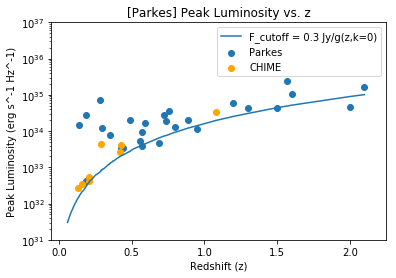

In [24]:
fig, ax = graphLz(L_p, z, d_L, k=0, TELESCOPE=NEW_PARKES, L_str='L_p')
ax.scatter(z[54:], L_p[54:], color='orange', label = 'CHIME')
plt.title('[Parkes] Peak Luminosity vs. z')
plt.ylabel('Peak Luminosity (erg s^-1 Hz^-1)')
plt.xlabel('Redshift (z)')
plt.legend()
plt.show()
hide_toggle()

### log(L) vs. log (1+z)

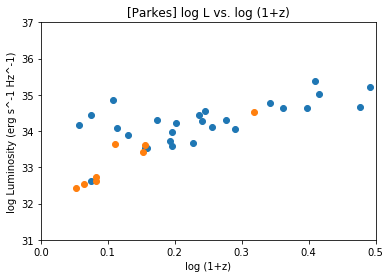

In [25]:
fig, ax = plt.subplots()
ax.scatter(np.log10(1+z)[NEW_PARKES[0]], np.log10(L_p)[NEW_PARKES[0]], label = 'Parkes')
ax.scatter(np.log10(1+z)[54:], np.log10(L_p)[54:], label = 'CHIME')
plt.ylim([31, 37])
plt.xlim([0, 0.5])
plt.ylabel('log Luminosity (erg s^-1 Hz^-1)')
plt.xlabel('log (1+z)')
plt.title('[Parkes] log L vs. log (1+z)')
plt.show()
hide_toggle()

### Kendall Tau, both methods

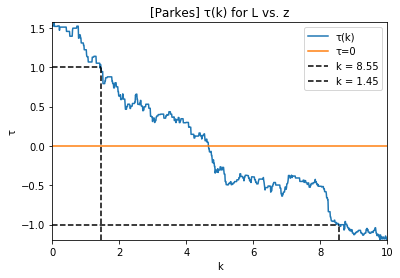

In [26]:
fig, ax, k0 = tk_pandas(data, k_min=0, k_max=10, TELESCOPE=PAC)
plt.title('[Parkes] τ(k) for L vs. z')
hide_toggle()

In [28]:
data.iloc[PAC[0]]

,frb,telescope,snr,f_p,d_L,z,L_p,L_lim,DM,W,fl
27,FRB010305,parkes,10.2,4.20,1.57,0.30,1.238681e+34,8.847723e+32,350.00,9.000,37.8000
28,FRB010125,parkes,17.0,0.30,3.33,0.57,3.980345e+33,3.980345e+33,790.00,9.400,2.8200
29,FRB010312,parkes,11.0,0.25,6.26,0.95,1.172194e+34,1.406633e+34,1187.00,24.300,6.0750
30,FRB010621,parkes,16.3,0.41,0.92,0.19,4.152125e+32,3.038141e+32,745.00,7.000,2.8700
31,FRB010724,parkes,23.0,30.00,1.42,0.28,7.237839e+34,7.237839e+32,375.00,5.000,150.0000
32,FRB090625,parkes,30.0,1.14,4.49,0.72,2.749847e+34,7.236439e+33,899.55,1.920,2.1888
33,FRB110214,parkes,13.0,27.00,0.67,0.14,1.450188e+34,1.611320e+32,168.90,1.900,51.3000
34,FRB110220,parkes,49.0,1.30,4.76,0.76,3.524262e+34,8.132913e+33,944.38,5.600,7.2800
35,FRB110626,parkes,11.0,0.40,3.30,0.56,5.211933e+33,3.908950e+33,723.00,1.400,0.5600
36,FRB110703,parkes,16.0,0.50,5.82,0.89,2.026408e+34,1.215845e+34,1103.60,4.300,2.1500


In [27]:
print(k0)
hide_toggle()

4.66


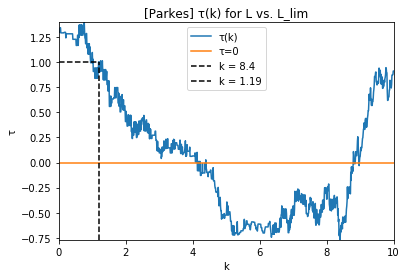

In [82]:
fig, ax, k0 = tk2_pandas(data, k_min=0, k_max=10, TELESCOPE=PAC)
plt.title('[Parkes] τ(k) for L vs. L_lim')
hide_toggle()

In [83]:
print(k0)
hide_toggle()

4.37


since it seems k~2 is the closest to 0, with error bars of ±2, the values of k used from now on will be k = 0,2,4

### dot sigma(z)
sigma0-4, z0-4  
rawL, rawz, rawdL  
rawLF(), z_, N  
graph

In [84]:
sigma0, z_0 = sigma_z(L_p, z, d_L, k=0, TELESCOPE=PAC)
sigma2, z_2 = sigma_z(L_p, z, d_L, k=2, TELESCOPE=PAC)
sigma4, z_4 = sigma_z(L_p, z, d_L, k=4, TELESCOPE=PAC)
hide_toggle()

0.69
0.95
2.0
0.69
0.95
2.0
0.69
0.95
2.0


In [85]:
rawL = L_p[27:]
rawz = z[27:]
rawdL = d_L[27:]

rawL = np.delete(rawL, [14,2,25])
rawz = np.delete(rawz, [14,2,25])
rawdL = np.delete(rawdL, [14,2,25])
hide_toggle()

In [31]:
def rawLF(L_p, z, d_L):
    z_, L_p_, d_L_ = sort_by_1(z, L_p, d_L)
    N = [i for i in range(1, len(z_)+1)] # 1 to N inclusive
    return z_, N

z_, N = rawLF(rawL, rawz, rawdL)
hide_toggle()

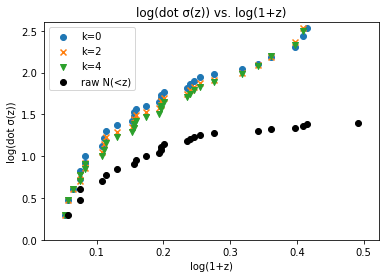

In [86]:
fig, ax = plt.subplots()
ax.scatter(np.log10(1+np.array(z_0)), np.log10(sigma0), label='k=0')
ax.scatter(np.log10(1+np.array(z_2)), np.log10(sigma2), label='k=2', marker='x')
ax.scatter(np.log10(1+np.array(z_4)), np.log10(sigma4), label='k=4', marker='v')
#plt.xlim([0, 0.6])
plt.ylim([0, 2.6])
plt.title(f'log(dot σ(z)) vs. log(1+z)')
plt.xlabel('log(1+z)')
plt.ylabel('log(dot σ(z))')

ax.scatter(np.log10(1+np.array(z_)), np.log10(np.array(N)+1), label='raw N(<z)', color='black')

#plt.ylabel('log N(<z)')
#plt.xlabel('log (1+z)')
#plt.title('log N(<z) vs. log(1+z)')

ax.legend()

#plt.savefig('dotsigma.png', dpi=300)
plt.show()
hide_toggle()

### phi(L')
zrange, L_cutoffs, phi0-4, Lprime 0-4  
rawPhi(), L_p_, NPhi  
graph  

In [87]:
#NN_PARKES = (slice(27, 54), 'Parkes', 0.3, 'ff7f0e') #about as close as i can get to 0.30 without cutting off additional points
zrange, L_cutoffs = create_Lcutoffs(TELESCOPE=NEW_PARKES)
phi0, Lprime0 = phi_L(L_p, z, k=0, L_cutoffs=L_cutoffs, zrange=zrange, TELESCOPE=PAC)
phi2, Lprime2 = phi_L(L_p, z, k=2, L_cutoffs=L_cutoffs, zrange=zrange, TELESCOPE=PAC)
phi4, Lprime4 = phi_L(L_p, z, k=4, L_cutoffs=L_cutoffs, zrange=zrange, TELESCOPE=PAC)
hide_toggle()

2.0
0.95
0.69
2.0
0.95
0.69
2.0
0.95
0.69


In [88]:
def rawPhi(L_p, z, d_L):
    L_p_, z_, d_L_ = sort_by_1(L_p, z, d_L, reverse=True)
    N = [i for i in range(1, len(L_p_)+1)]
    return L_p_, N

L_p_, NPhi = rawPhi(rawL, rawz, rawdL)
hide_toggle()

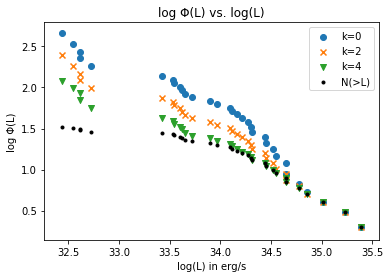

In [89]:
fig, ax = plt.subplots()
ax.scatter(np.log10(Lprime0), np.log10(phi0), label='k=0')
ax.scatter(np.log10(Lprime0), np.log10(phi2), label='k=2', marker='x')
ax.scatter(np.log10(Lprime0), np.log10(phi4), label='k=4', marker='v')
ax.scatter(np.log10(L_p_), np.log10(np.array(NPhi)+1), label='N(>L)', color='black', marker='.')
ax.legend()
#plt.ylim(0, 2.25)
#plt.xlim(32.5, 35.5)
plt.xlabel('log(L) in erg/s')
plt.ylabel('log Φ(L)')
plt.title(f'log Φ(L) vs. log(L)')
#plt.savefig('phi(L) new.png', dpi=300)
plt.show()
hide_toggle()

## dot rho
devSig, devPhi  
manual_dL, manual_Llim, manual_dVdz  
rho_z

In [90]:
def devSig(z, d1, d2, Z_c, n):
    Z = z+1.0
    fac1 = np.power(Z, d1-1.0)
    fac2 = np.power(np.power(Z/Z_c, n*(d1-d2))+1.0, -1.0/n - 1.0)
    fac3 = d2*np.power(Z/Z_c, n*(d1-d2))+d1
    return fac1*fac2*fac3

def devPhi(L, Phi_0, L_0, d1, d2, n):
    ratio = L/L_0
    fac1 = Phi_0 * np.power(1+ np.power(ratio, n*(d2-d1)), -1.0/n -1.0)
    fac2 = d2*np.power(ratio, n*(d2-d1))+d1
    fac3 = L*np.power(ratio, d1)
    return fac1*fac2/fac3
hide_toggle()

In [42]:
def manual_dL(z, O_M=0.286, O_V=0.714, H_0=69.6, dz = 1e-5, prev=None):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    if prev: #already integrated up to a certain point
        z_cur, d_L = prev #assume format is [z, d_L]
        integral = d_L/(d_H*(1+z_cur))
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    return integral*(1+z)*d_H

def manual_Llim(F_lim, z_i, g=g_new, k=0, prev=None):
    if not prev:
        return (F_lim*1e-19)*4*math.pi*(manual_dL(z_i, prev=prev))**2/g(z_i, k)
    d_L = manual_dL(z_i, prev=prev)
    return [(F_lim*1e-19)*4*math.pi*(d_L)**2/g(z_i, k), d_L]

def manual_dVdz(z, O_M=0.286, O_V=0.714, H_0=69.6, dz= 1e-5, prev=None):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    if prev:
        z_cur, integral = prev
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    if not prev:
        return 4*math.pi*(d_H**3)*integral**2/(O_M*(1+z_cur)**3 + O_V)**0.5
    return [4*math.pi*(d_H**3)*integral**2/(O_M*(1+z_cur)**3 + O_V)**0.5, integral]

hide_toggle()

In [51]:
def rho_z(sigma, z_, argsSig):
    dSdz = devSig(z_, *argsSig)
    
    z_cur = 0
    i = 0
    dz = 1e-5
    
    prev = (0, 0)
    
    dVdz = []
    
    while(i < len(z_)):
        dVdzi, integral = manual_dVdz(z_[i], prev=prev)
        prev = (z_[i], integral)
        dVdz.append(dVdzi)
        i += 1
    
    return [(1+z_[i])*dSdz[i]/dVdz[i] for i in range(len(z_))]
hide_toggle()

In [53]:
argsSig0 = np.array([6.6284342, 3.16253072, 1.48414957, 7.84493569])
rho = rho_z(sigma0, np.array(z_0), argsSig0)
rho = np.array(rho)*2.93799894e67
hide_toggle()

In [54]:
argsSigRaw = np.array([6.82541666, 0.48318052, 1.52510186, 1.5272636])
z_, N = rawLF(rawL, rawz, rawdL)
rawrho = rho_z(np.array(N)+1, np.array(z_), argsSigRaw)
rawrho = np.array(rawrho)*2.93799894e67
hide_toggle()

In [66]:
normrho = np.array(rho)/rho[0]
normrawrho= np.array(rawrho)/rawrho[0]

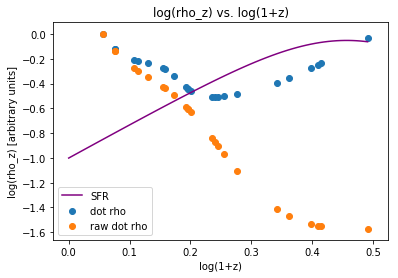

In [71]:
fig, ax = plt.subplots()
ax.scatter(np.log10(1+np.array(z_0)), np.log10(normrho), label='dot rho')
ax.scatter(np.log10(1+np.array(z_)), np.log10(normrawrho), label='raw dot rho')
Z = np.linspace(1, 3.1, 50)
ax.plot(np.log10(Z), np.log10(0.1*SFR(Z)), color='purple', label = 'SFR')
plt.title('log(rho_z) vs. log(1+z)')
plt.ylabel('log(rho_z) [arbitrary units]')
plt.xlabel('log(1+z)')
plt.legend()
#plt.savefig('rhovsz.jpg', dpi=300)
hide_toggle()

In [56]:
def SFR(Z):
    return np.power(Z, 2.7)/(1 + np.power(Z/2.9, 5.6))

3.486017063065465

# Debug

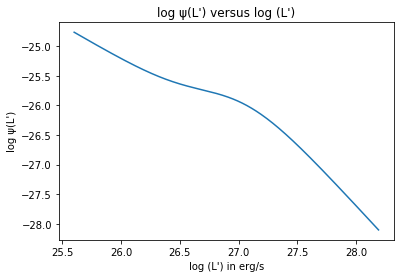

In [48]:
def customfunc(ratio):
    num = 115*(ratio**1.98)+16
    denom = 100*(ratio**1.16) * (ratio**1.98 + 1)**1.5
    return num/denom

def psi_L(PSI_0, L0, L):
    fact = customfunc(L/L0)
    return PSI_0*fact/L0

#x from 10^25.6 to 10^28.2

psi = []
Ls = np.power(10, np.arange(25.6, 28.2, 0.01))
for L in Ls:
    psi.append(psi_L(10**1.4, 10**27, L))

otherLs = np.array(data['L_p'])

fig, ax = plt.subplots()
ax.plot(np.log10(Ls), np.log10(psi))
plt.title('log ψ(L\') versus log (L\')')
plt.ylabel('log ψ(L\')')
plt.xlabel('log (L\') in erg/s')
plt.show()

In [49]:
def rawLF(L_p, z, d_L):
    z_, L_p_, d_L_ = sort_by_1(z, L_p, d_L)
    N = [i for i in range(1, len(z_)+1)] # 1 to N inclusive
    return z_, N

z_, N = rawLF(rawL, rawz, rawdL)

In [50]:
def func_phi(L, Phi_0, L_0, d1, d2, n):
    ratio = np.divide(L, L_0)
    return Phi_0*np.divide(np.power(ratio, -d1), np.power(1.0+np.power(ratio, n*(d2-d1)), 1.0/n))

In [51]:
def func_sigma(Z, d1, d2, Z_c, n):
    ratio = np.divide(Z, Z_c)
    return np.divide(np.power(Z, d1), np.power(1.0 + np.power(ratio, n*(d1-d2)), 1.0/n))

In [52]:
def logsigma(logZ, d1, d2, Z_c, n):
    return np.log10(func_sigma(np.power(10.0, logZ), d1, d2, Z_c, n))

def logphi(logL, logP, logL0, d1, d2, n):
    #original: logP - d1*(logL-logP) - (1/n)*np.log10(1 + np.power(np.power(10, logL-logL0), n*(d2-d1)))
    return logP - d1*(logL-logL0) - (1/n)*np.log10(1 + np.power(np.power(10, logL-logL0), n*(d2-d1)))

In [53]:
import scipy.optimize as opt

xdata = 1+np.array(z_)
ydata = np.array(N)

In [54]:
guess = [5.8, 0.45, 1.66, 2.0]
guess2 = [6.4, 1.45, 1.58, 1.8]
bounds = [[-10, -10, -10, -10], [10, 10, 10, 10]]
print('starting fitting')
optrawsig, pcov = opt.curve_fit(func_sigma, xdata, ydata+1, guess, bounds=bounds)
optsig, pcov_ = opt.curve_fit(func_sigma, 1+np.array(z_0), sigma0, guess2, bounds=bounds)
#optsig, pcov_ = opt.curve_fit(logsigma, np.log10(1+np.array(z_0)), np.log10(sigma0), guess2, bounds=bounds)
print('done')

starting fitting
done


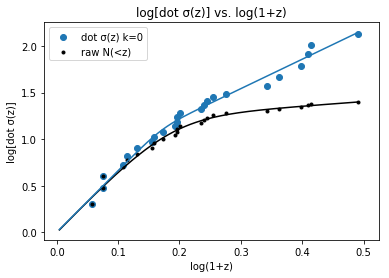

In [55]:
fig, ax = plt.subplots()

ax.scatter(np.log10(1+np.array(z_0)), np.log10(sigma0), label='dot σ(z) k=0')
ax.scatter(np.log10(xdata), np.log10(ydata+1), label='raw N(<z)', color='black', marker='.')

modelzs = np.linspace(0.01, 2.1, 2000)
ax.plot(np.log10(1+modelzs), np.log10(func_sigma(1+modelzs, *optrawsig)), color='black')
ax.plot(np.log10(1+modelzs), np.log10(func_sigma(1+modelzs, *optsig)))
#plt.ylim([0, 2.5])
#plt.xlim([0, 0.5])
plt.xlabel('log(1+z)')
plt.ylabel('log[dot σ(z)]')
plt.title('log[dot σ(z)] vs. log(1+z)')
plt.legend()
#plt.savefig('dotsigmaNEW.png', dpi=300)
plt.show()

In [56]:
print(optrawsig)
print(optsig)

#regular: [7.34989559 4.07433753 1.27965648 9.99999994]
#log: [6.92286354 3.76819259 1.3917929  8.22661275]
# [5.744095   0.58936131 1.63170925 2.81907488]
# [6.92286354 3.76819259 1.3917929  8.22661275]

[6.82542166 0.48318274 1.52510106 1.52726366]
[6.6285091  3.16257977 1.48412362 7.85367479]


In [46]:
guess = [2.7, 34.0, 0.04, 1.15, 1.0]
guess2 = [2.0, 34.0, 1.0, 1.5, 2.0]
guess3 = [1.6, 34.0, 0.16, 1.35, 1.0]
bounds = [[0.0, 30.0, 0.0, 0.0, 0.0], [10.0, 40.0, 10.0, 10.0, 10.0]]
print('starting fitting')
optrawphi, pcov = opt.curve_fit(logphi, np.log10(L_p_), np.log10(NPhi), guess, bounds=bounds)
optphi, pcov_ = opt.curve_fit(logphi, np.log10(Lprime2), np.log10(phi2), guess3, bounds=bounds)
print('done')

starting fitting
done


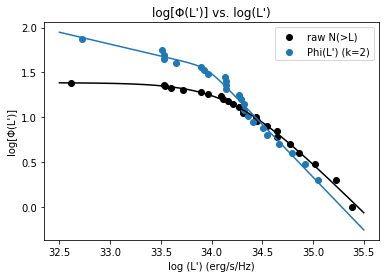

In [47]:
fig, ax = plt.subplots()
ax.scatter(np.log10(L_p_), np.log10(NPhi), label='raw N(>L)', color='black')
ax.scatter(np.log10(Lprime2), np.log10(phi2), label='Phi(L\') (k=2)')

modelLs = np.linspace(32.5, 35.5, 2000)
ax.plot(modelLs, logphi(modelLs, *optrawphi), color='black')
ax.plot(modelLs, logphi(modelLs, *optphi))
plt.legend()
plt.xlabel('log (L\') (erg/s/Hz)')
plt.ylabel('log[Φ(L\')]')
plt.title('log[Φ(L\')] vs. log(L\')')
#plt.savefig('cumulativeLFfit.png', dpi=300)
plt.show()

In [48]:
print(optphi)
print(optrawphi)

[ 1.56219096 33.95387754  0.26498847  1.17780921  7.29468816]
[1.38440006e+00 3.42091974e+01 5.43911577e-13 1.12020649e+00
 1.23944549e+00]


In [49]:
# array([1.38439906e+00, 3.42091925e+01, 1.05472389e-15, 1.12020073e+00,
#        1.23946603e+00])
#array([1.38439892e+00, 3.42091918e+01, 1.44582557e-14, 1.12019994e+00,
#       1.23946888e+00])

In [50]:
optrawphi

array([1.38440006e+00, 3.42091974e+01, 5.43911577e-13, 1.12020649e+00,
       1.23944549e+00])

In [51]:
def convert(arr):
    newarr = np.power(arr, 1)
    newarr[0:2] = np.power(10.0, arr[0:2])
    return newarr

In [52]:
optphi

array([ 1.56219096, 33.95387754,  0.26498847,  1.17780921,  7.29468816])

In [53]:
L= 10**34
logP0, logL0, d1, d2, n = guess

ratio = np.divide(L, np.power(10.0, logL0))
a = np.power(10.0, logP0)*np.divide(np.power(ratio, -d1), np.power(1.0+np.power(ratio, n*(d2-d1)), 1.0/n))
print(a)

250.59361681363623


In [54]:
np.power(10.0, logL0)

1e+34

In [55]:
betterphi(10**34, *guess)

NameError: name 'betterphi' is not defined